- Use dynamic functional connectivity
- Find correlation between ROIs based on cc400 atlas, using a sliding time window approach
- window size will be 70 Time points , step size 1 Time point `https://www.ncbi.nlm.nih.gov/pmc/articles/PMC6549695/`
- Pearson's correlation coefficent will be used to compute a matrix,
- this matrix will be the iput for CNN

https://www.ncbi.nlm.nih.gov/pmc/articles/PMC8514188/ suggests using a window size of 50TR or 100s
-https://onlinelibrary.wiley.com/doi/full/10.1002/brb3.1255 suggests a window size of at least 120s 60TR

## Network choices

- CNN
- Reccurrent Convolution neural network, utilising LSTM layer to capture sequential data. (https://www.frontiersin.org/articles/10.3389/fnins.2022.933660/full)


In [46]:
import pandas as pd
import numpy as np
import os
import matplotlib.pyplot as plt
import seaborn as sns
import pickle

In [47]:
parent_dir = os.path.dirname(os.getcwd()) # get parent directory
data_dir = os.path.join(parent_dir, 'rois_cc200') # get directory for roi_cc200 files
phenotype_path = os.path.join(parent_dir,'phenotype_files/pheno_clean.csv') # path to phenotype file

In [48]:
df = pd.read_csv(phenotype_path) # load the phenotype data

In [49]:
df.head()

,SITE_ID,X,SUB_ID,FILE_ID,AGE_AT_SCAN,SEX,DSM_IV_TR,DX_GROUP
0,PITT,1,50002,Pitt_0050002,16.77,1,1,1
1,PITT,2,50003,Pitt_0050003,24.45,1,1,1
2,PITT,3,50004,Pitt_0050004,19.09,1,1,1
3,PITT,4,50005,Pitt_0050005,13.73,2,1,1
4,PITT,5,50006,Pitt_0050006,13.37,1,1,1


In [50]:
# all roi timeseries filenames
roi_files = [os.path.join(data_dir, df.FILE_ID[i] + '_rois_cc200.1D') for i in range(len(df))]

In [52]:
# load a time series file
ts1 = pd.read_csv(roi_files[0], sep= '\t', lineterminator= '\n')

In [53]:
"""
plotting roi timeseries data
"""
def plot_roi(data,roi1,roi2):
    """
    :param data: roi dataframe
    :param roi1: roi number
    :param roi2:roi number
    :return:
    """
    plt.figure(figsize= (10,5))
    plt.plot(data.iloc[:,roi1-1]) # plot 1st roi timeseries due to 0 indexing minus roi number by 1
    plt.plot(data.iloc[:,roi2-1])
    plt.xlabel("time point")
    plt.ylabel("Signal level")
    plt.title(f"ROI #{roi1} & #{roi2} ")
    plt.legend((f"#{roi1}",f"#{roi2}"))
    plt.show()

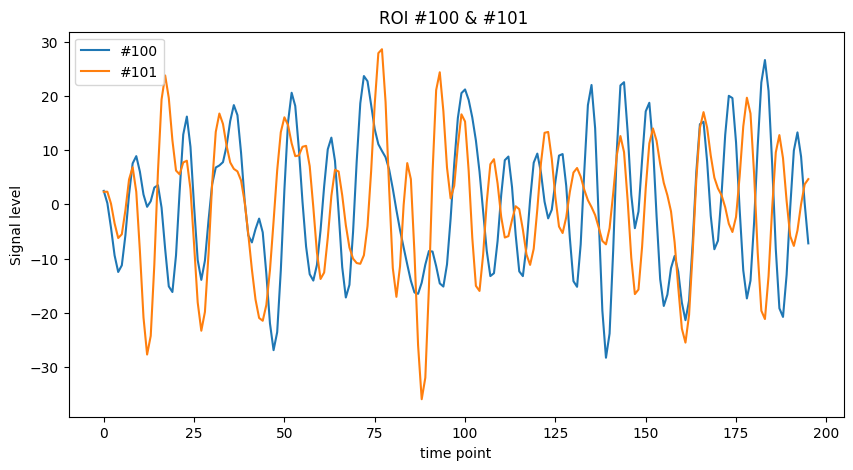

In [54]:
# an example of two rois
plot_roi(ts1,100,101)

In [ ]:
corrs =ts1.corr(method = 'pearson')

In [ ]:
plt.figure(figsize= (20,20))
sns.heatmap(corrs, annot=False, center = 0)
plt.show()

## Dynamic functional correlation (dFC)

number of time points to be used is 116
- first 5 will be removed as advised by literature
- therefore 111 timepoints available for analysis.
- 90 temporal windows available (111-22 +1)



In [ ]:
ts1

#### calculating dFC time window 22

In [ ]:
dFC1 = [] # store dFC data array
for i in range(len(ts1)):
    if (i + 22) <= len(ts1):# to stop rolling window from exceeding timepoints
        dFC1.append(ts1.iloc[i:i+22].corr(method= 'pearson'))# find correlation within a 22 point window
    else: #if window exceeds length of timeseries break operation
        break


In [ ]:
dFC1

Adopt above operation, and automate process for all timeseries data.
The functions for calculatinf DFC will be stored in dfc_functions

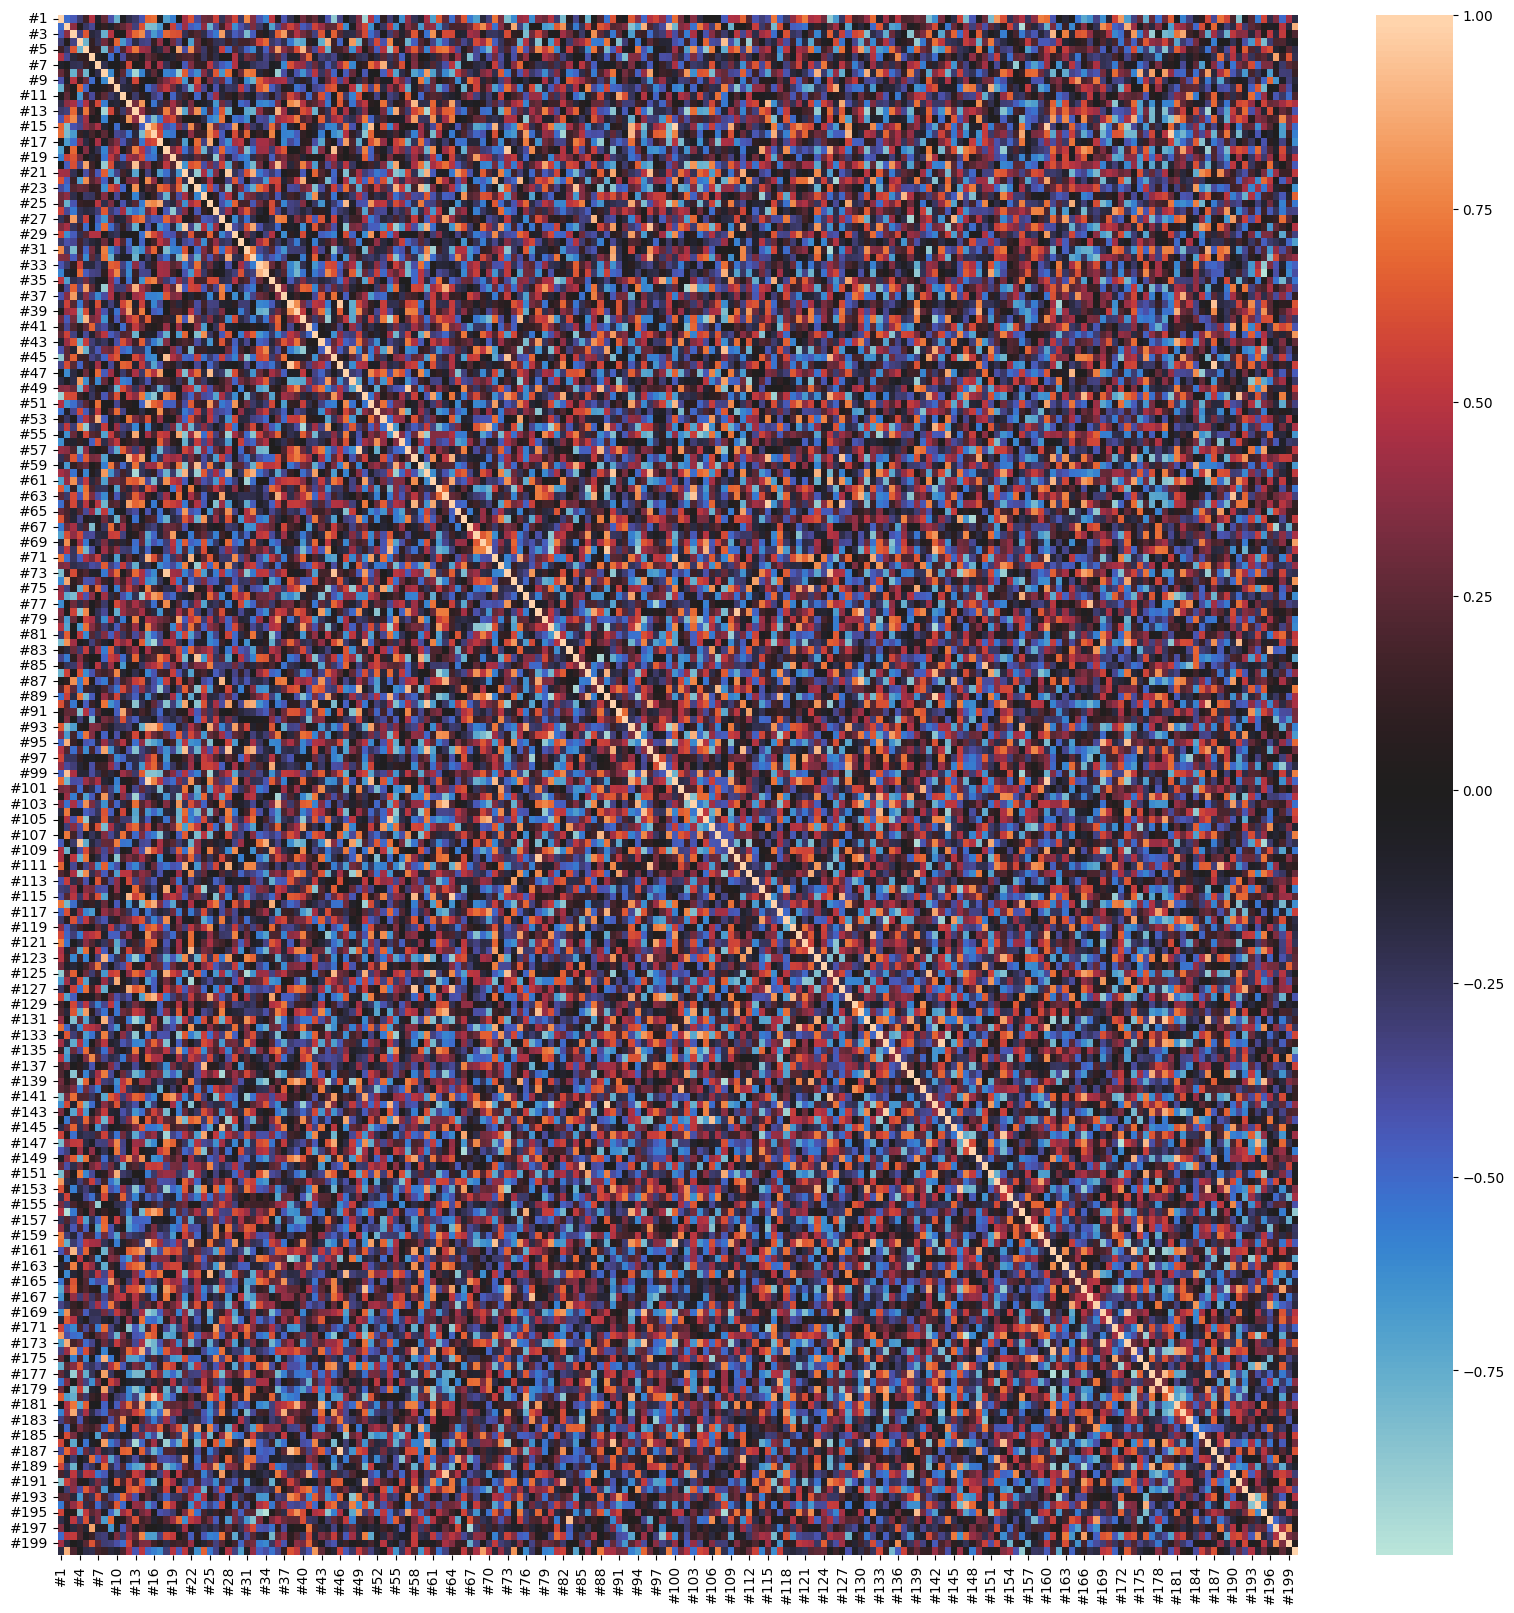

In [45]:
"""
display heatmap of one time window of correlation values
"""
plt.figure(figsize= (20,20))
sns.heatmap(dFC1[90], annot=False, center = 0)
plt.show()

## calculate dfc time window 70

In [ ]:
d_check = ts1.iloc[5:116, :]

In [ ]:
dFC2 = [] # store dFC data in dictionary, with time window number as key and correlation matrix as value
for i in range(len(d_check)):
    if (i + 70) <= len(d_check):# to stop rolling window from exceeding timepoints
        dFC2.append(d_check.iloc[i:i+70].corr(method= 'pearson'))# find correlation within a 22 point window
    else: #if window exceeds length of timeseries break operation
        break


In [ ]:
len(dFC2)

In [ ]:
plt.figure(figsize= (10,10))
sns.heatmap(dFC2[20], annot=False, center = 0)
plt.show()

Automate with dfc_maker script file using functions in feature_extraction package

While calculating DFC arrays, a divide by zero error occured at File_ID 'Caltech_0051457', indicating a roi column with 0 variance

In [ ]:
pheno_df = pd.read_csv(phenotype_path)

In [ ]:
pheno_df[pheno_df['FILE_ID']== 'Caltech_0051457'] # get all data on this subject

To investigate why the null values are present I will look at the time series data

In [ ]:
missing_ts = pd.read_csv(os.path.join( data_dir, 'Caltech_0051457_rois_cc200.1D'), sep= '\t', lineterminator= '\n') # get Time Series Data

In [ ]:
# look for column with zero variance
for i in range(len(missing_ts)):
    variance =  missing_ts.iloc[:,i].var()
    if variance == 0:
        print(i)

In [ ]:
plot_roi(missing_ts,1,43) # visualise time series of missing roi and another non missing roi

The ROI with 0 variance is a flatline at zero, can be construed as null values. This issue could be happening in other samples as well. subjects with Null values will be detected and removed from phenytype description file in the notebook `EDA_notebooks/phenotype_EDA.ipynb`